# Patient Readmission Prediction

## Installing Required Libraries

In [31]:
pip install pandas numpy scikit-learn imbalanced-learn shap matplotlib seaborn flask joblib


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

## Loading and Preprocessing Data

In [33]:
# Load Data
df = pd.read_csv("diabetic_data.csv")


In [34]:
# Replace '?' with NaN
df = df.replace('?', np.nan)

In [35]:
# Encode 'readmitted' Target Variable
readmitted_map = {'<30': 1, '>30': 0, 'NO': 0}
df['readmitted'] = df['readmitted'].map(readmitted_map)

In [36]:
# Convert 'age' to numeric
age_map = {'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
           '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
           '[80-90)': 85, '[90-100)': 95}
df['age'] = df['age'].map(age_map)

In [37]:
# Handle Missing Values
df['weight'] = pd.to_numeric(df['weight'], errors='coerce')
mice_imputer = IterativeImputer(estimator=RandomForestRegressor(), random_state=42)
df['weight'] = mice_imputer.fit_transform(df[['weight', 'age', 'time_in_hospital', 'num_medications']])[:, 0]
df['weight_imputed'] = df['weight'].isna().astype(int)

/Users/vaishnavimada/my_project/venv/lib/python3.13/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [38]:
for col in ['race', 'diag_1', 'diag_2', 'diag_3']:
    df[col] = df[col].fillna('Unknown')
for col in ['max_glu_serum', 'A1Cresult']:
    df[col] = df[col].fillna('Not Tested')

In [39]:
df = df.drop(['payer_code', 'medical_specialty'], axis=1)  # Drop columns with high missing values

encounter_id                        0
patient_nbr                         0
age                                 0
weight                              0
admission_type_id                   0
                                   ..
age_time_in_hospital                0
num_medications_time_in_hospital    0
num_diagnoses                       0
stay_severity_medium                0
stay_severity_long                  0
Length: 63, dtype: int64


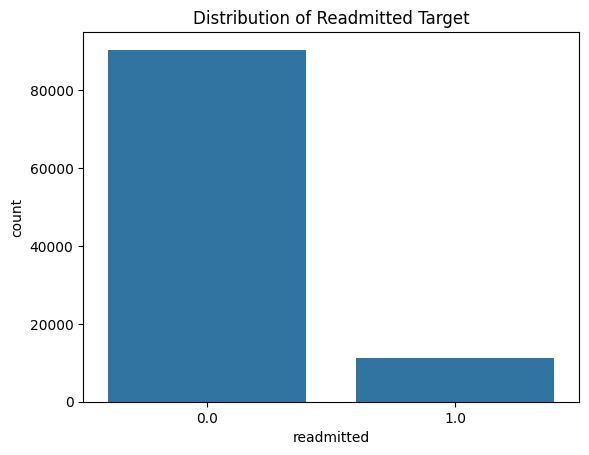

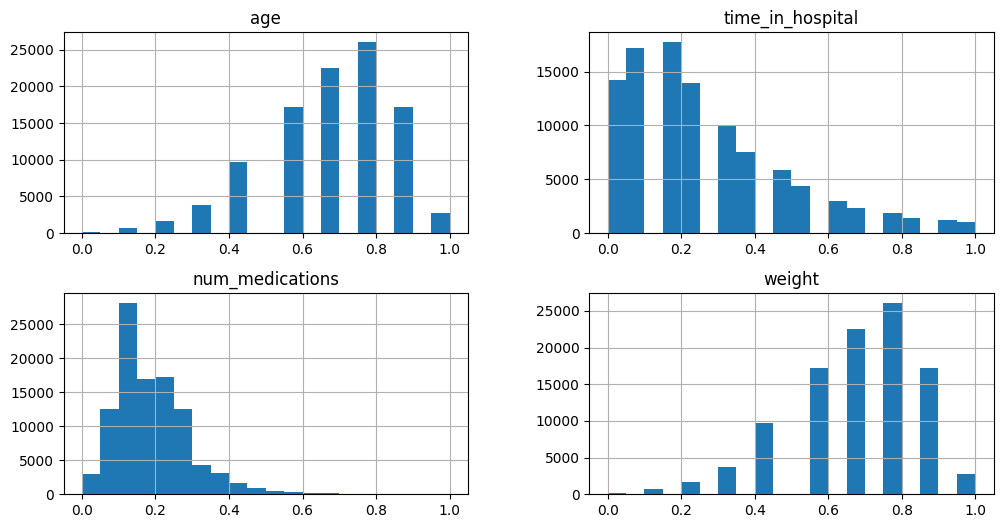

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check for missing values
missing_data = df.isnull().sum()
print(missing_data)

# Visualize distribution of the target variable (readmitted)
sns.countplot(data=df, x='readmitted')
plt.title('Distribution of Readmitted Target')
plt.show()

# Visualize distribution of numeric features
df[['age', 'time_in_hospital', 'num_medications', 'weight']].hist(bins=20, figsize=(12, 6))
plt.show()



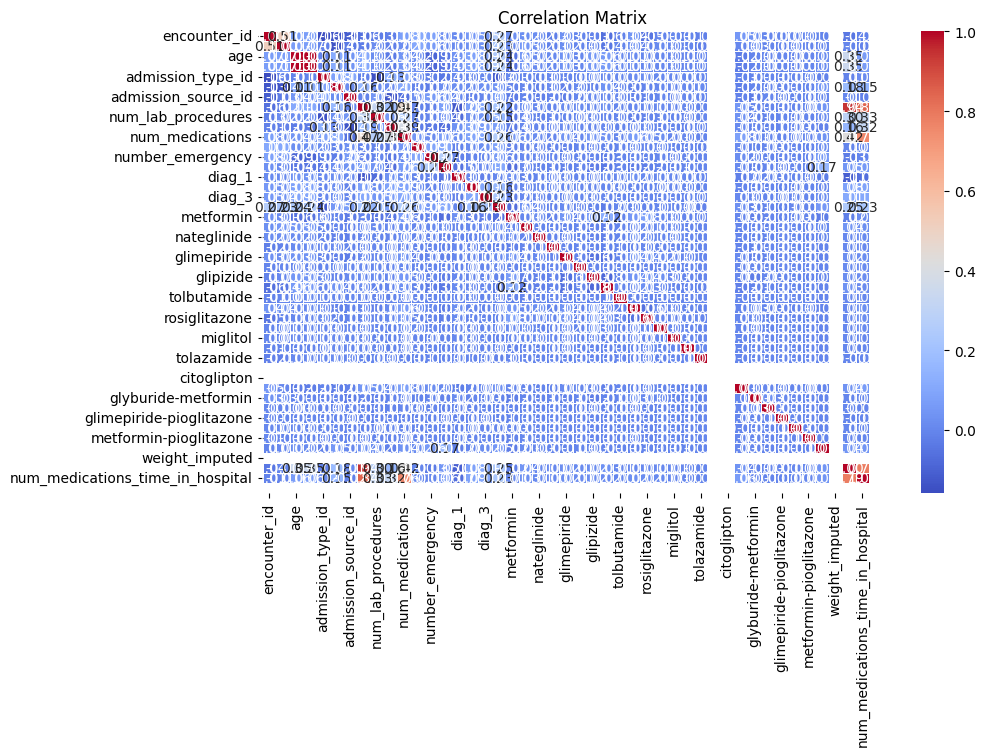

In [65]:
# Select only numeric columns for correlation
numeric_cols = df.select_dtypes(include=['number']).columns
correlation_matrix = df[numeric_cols].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


### Feature Engineering

In [40]:
# One-Hot Encoding
one_hot_cols = ['race', 'gender', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed']
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

In [41]:
# Categorize ICD-9 Codes
def categorize_icd9(code):
    try:
        if code.startswith('V') or code.startswith('E'):
            return 0  # Special cases
        else:
            return int(float(code)) // 100  # Group by hundreds
    except:
        return -1  # Assign -1 for missing/unknown values

for col in ['diag_1', 'diag_2', 'diag_3']:
    df[col] = df[col].astype(str).map(categorize_icd9)

In [42]:
# Encode Medication Columns
medication_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
                   'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
                   'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin',
                   'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone',
                   'metformin-rosiglitazone', 'metformin-pioglitazone']

In [43]:

df[medication_cols] = df[medication_cols].astype(str)

In [44]:
# Create consistent label encoding
unique_categories = {col: sorted(set(df[col].unique())) for col in medication_cols}
for col in medication_cols:
    category_map = {value: idx for idx, value in enumerate(unique_categories[col])}
    df[col] = df[col].map(category_map)

In [45]:
# Scale Numeric Features
numeric_cols = df.select_dtypes(include=['number']).columns
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [ ]:
## Train-Test Split & Handling Imbalance

In [46]:
# Train-Test Split
y = df['readmitted'].copy() # Extract target variable
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42, stratify=y)

In [47]:
# Handle Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [54]:
from sklearn.model_selection import train_test_split

# Ensure 'readmitted' is removed properly
y = df['readmitted'].copy()  # Copy target variable
X = df.drop(columns=['readmitted'])  # Ensure it is removed from features

# Proper train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)


In [55]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Do NOT apply SMOTE to X_test and y_test


## Training Machine Learning Models

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Logistic Regression
log_reg = LogisticRegression(random_state=42,max_iter=500)
log_reg.fit(X_train_resampled, y_train_resampled)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# XGBoost with correct objective
xgb = XGBClassifier(eval_metric='logloss', objective='binary:logistic', random_state=42)
xgb.fit(X_train_resampled, y_train_resampled)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)


--- Logistic Regression Model Evaluation ---
Accuracy: 0.6526
Precision: 0.1668
Recall: 0.5288
F1 Score: 0.2536
ROC-AUC Score: 0.6411

Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.67      0.77     18083
         1.0       0.17      0.53      0.25      2271

    accuracy                           0.65     20354
   macro avg       0.54      0.60      0.51     20354
weighted avg       0.83      0.65      0.72     20354


--- Random Forest Model Evaluation ---
Accuracy: 0.8880
Precision: 0.4592
Recall: 0.0198
F1 Score: 0.0380
ROC-AUC Score: 0.6417

Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      1.00      0.94     18083
         1.0       0.46      0.02      0.04      2271

    accuracy                           0.89     20354
   macro avg       0.67      0.51      0.49     20354
weighted avg       0.84      0.89      0.84     20354


--- XGBoost Model Evaluation --

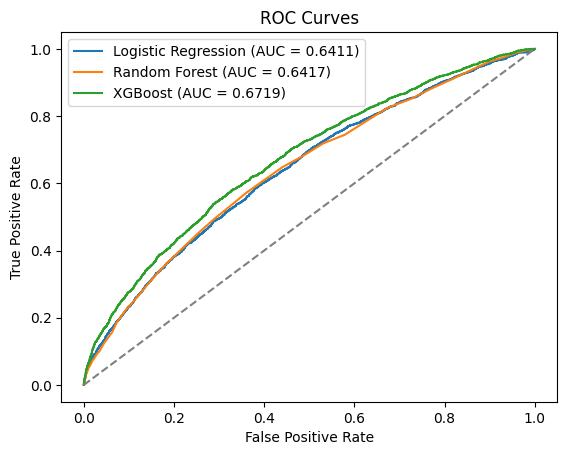

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt

# Function to evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)  # Predictions
    y_proba = model.predict_proba(X_test)[:, 1]  # Probability scores for ROC-AUC

    print(f"\n--- {model_name} Model Evaluation ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_test, y_proba):.4f})')

# Evaluate models
evaluate_model(log_reg, X_test, y_test, "Logistic Regression")
evaluate_model(rf, X_test, y_test, "Random Forest")
evaluate_model(xgb, X_test, y_test, "XGBoost")

# Plot ROC Curves
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random model baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()


## Hyperparameter Tuning

In [58]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import EditedNearestNeighbours

# Use SMOTE-Tomek
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

# Alternative: SMOTE-ENN
# smote_enn = SMOTEENN(random_state=42)
# X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)


In [59]:
df['age_time_in_hospital'] = df['age'] * df['time_in_hospital']
df['num_medications_time_in_hospital'] = df['num_medications'] * df['time_in_hospital']


In [61]:
df['num_diagnoses'] = df[['diag_1', 'diag_2', 'diag_3']].apply(lambda x: (x != -1).sum(), axis=1)


In [62]:
df['stay_severity'] = pd.cut(df['time_in_hospital'], bins=[0, 3, 7, 14], labels=['short', 'medium', 'long'])
df = pd.get_dummies(df, columns=['stay_severity'], drop_first=True)


###Grid Search for Random Forest

In [66]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search_rf.fit(X_train_resampled, y_train_resampled)

# Best model
best_rf = grid_search_rf.best_estimator_


/Users/vaishnavimada/my_project/venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


### Randomized Search for XGBoost

In [89]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

xgb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_search = RandomizedSearchCV(XGBClassifier(eval_metric='logloss'), xgb_params, n_iter=10, scoring='f1', cv=3, random_state=42, n_jobs=-1)
xgb_search.fit(X_train_resampled, y_train_resampled)

# Best model
best_xgb = xgb_search.best_estimator_


## Model Evaluation

In [68]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predictions
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]  # Probability scores for ROC AUC

# Metrics
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# ROC AUC Score
print("Random Forest ROC AUC Score:", roc_auc_score(y_test, y_proba_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94     18083
         1.0       0.43      0.02      0.04      2271

    accuracy                           0.89     20354
   macro avg       0.66      0.51      0.49     20354
weighted avg       0.84      0.89      0.84     20354

Random Forest Confusion Matrix:
[[18024    59]
 [ 2226    45]]
Random Forest ROC AUC Score: 0.6501167630749477


In [69]:
# Predictions
y_pred_xgb = best_xgb.predict(X_test)
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]  # Probability scores for ROC AUC

# Metrics
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

# ROC AUC Score
print("XGBoost ROC AUC Score:", roc_auc_score(y_test, y_proba_xgb))


XGBoost Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94     18083
         1.0       0.55      0.02      0.04      2271

    accuracy                           0.89     20354
   macro avg       0.72      0.51      0.49     20354
weighted avg       0.85      0.89      0.84     20354

XGBoost Confusion Matrix:
[[18049    34]
 [ 2229    42]]
XGBoost ROC AUC Score: 0.6756986650893224


In [70]:


model_results = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost"],
    "F1 Score": [f1_score(y_test, y_pred_rf), f1_score(y_test, y_pred_xgb)],
    "ROC AUC": [roc_auc_score(y_test, y_proba_rf), roc_auc_score(y_test, y_proba_xgb)]
})

print(model_results)


           Model  F1 Score   ROC AUC
0  Random Forest  0.037895  0.650117
1        XGBoost  0.035790  0.675699


## Feature Importance Analysis

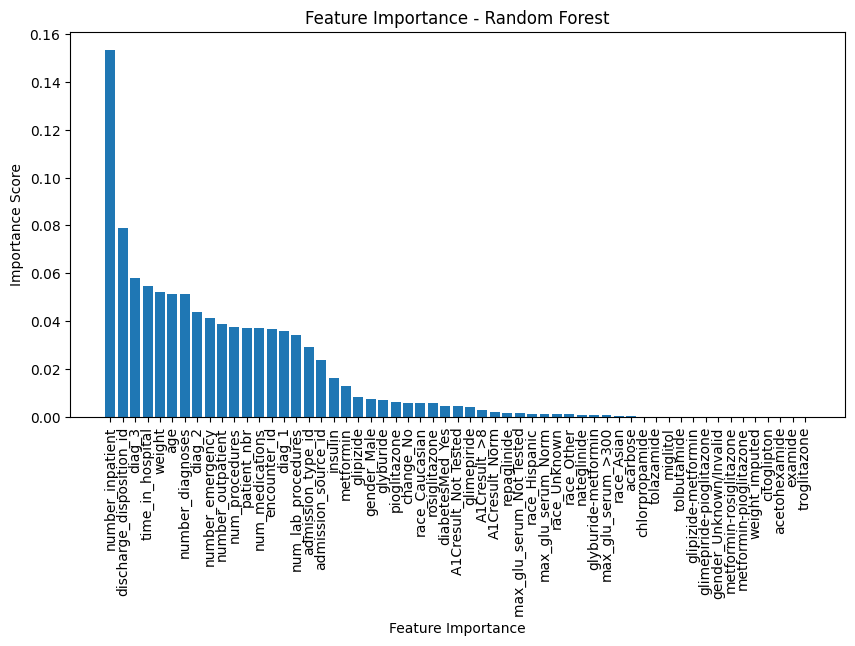

In [71]:
import matplotlib.pyplot as plt
import numpy as np

feature_importances_rf = best_rf.feature_importances_
indices_rf = np.argsort(feature_importances_rf)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(X_train_resampled.shape[1]), feature_importances_rf[indices_rf])
plt.xticks(range(X_train_resampled.shape[1]), X_train_resampled.columns[indices_rf], rotation=90)
plt.xlabel("Feature Importance")
plt.ylabel("Importance Score")
plt.title("Feature Importance - Random Forest")
plt.show()


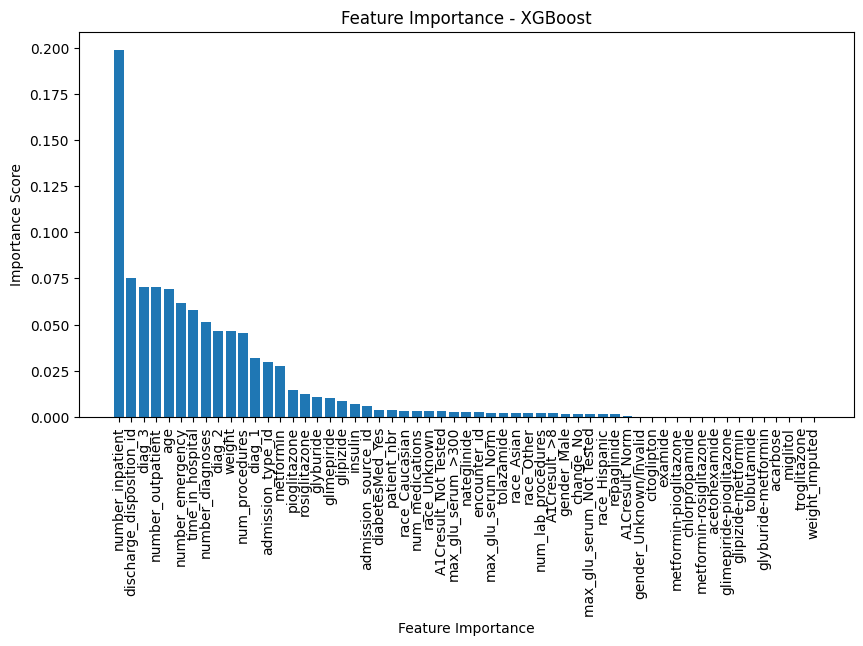

In [72]:
importances_xgb = best_xgb.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(X_train_resampled.shape[1]), importances_xgb[indices_xgb])
plt.xticks(range(X_train_resampled.shape[1]), X_train_resampled.columns[indices_xgb], rotation=90)
plt.xlabel("Feature Importance")
plt.ylabel("Importance Score")
plt.title("Feature Importance - XGBoost")
plt.show()


In [73]:
import joblib


joblib.dump(best_xgb, "best_xgb_model.pkl")  
joblib.dump(best_rf, "best_rf_model.pkl")    


['best_rf_model.pkl']

for laoding the saved model

In [ ]:
loaded_model = joblib.load("best_xgb_model.pkl")
predictions = loaded_model.predict(new_data)  # Provide new unseen data


## Threshold Optimization

In [74]:
from sklearn.metrics import precision_recall_curve

y_proba = best_xgb.predict_proba(X_test)[:, 1]  # Get probabilities
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Find the best threshold where recall is improved without killing precision
optimal_idx = np.argmax(recall - (1 - precision))  # Custom balance function
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")

# Apply New Threshold
y_pred_adjusted = (y_proba >= optimal_threshold).astype(int)

# Recalculate Metrics
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_adjusted))


Optimal Threshold: 0.024401552975177765
              precision    recall  f1-score   support

         0.0       1.00      0.00      0.00     18083
         1.0       0.11      1.00      0.20      2271

    accuracy                           0.11     20354
   macro avg       0.56      0.50      0.10     20354
weighted avg       0.90      0.11      0.02     20354



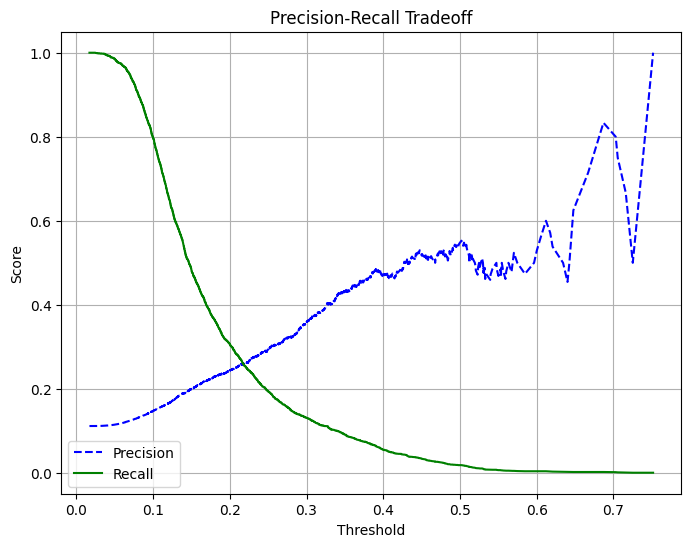

In [75]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

y_proba = best_xgb.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Precision-Recall Tradeoff")
plt.grid()
plt.show()


In [76]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

# Get model probabilities
y_proba = best_xgb.predict_proba(X_test)[:, 1]

# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Compute F1 scores for all thresholds
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the best threshold where F1 is highest
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold based on F1-score: {optimal_threshold}")

# Apply the new threshold
y_pred_adjusted = (y_proba >= optimal_threshold).astype(int)

# Evaluate performance
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_adjusted))


Optimal Threshold based on F1-score: 0.16550187766551971
              precision    recall  f1-score   support

         0.0       0.92      0.81      0.86     18083
         1.0       0.22      0.42      0.29      2271

    accuracy                           0.77     20354
   macro avg       0.57      0.61      0.57     20354
weighted avg       0.84      0.77      0.80     20354




--- Feature Importance Analysis ---
Selected Top 20 Features: ['number_inpatient', 'discharge_disposition_id', 'diag_3', 'number_outpatient', 'age', 'number_emergency', 'time_in_hospital', 'number_diagnoses', 'diag_2', 'weight', 'num_procedures', 'diag_1', 'admission_type_id', 'metformin', 'pioglitazone', 'rosiglitazone', 'glyburide', 'glimepiride', 'glipizide', 'insulin']

--- Retraining Models with Selected Features ---


/Users/vaishnavimada/my_project/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [21:39:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- Random Forest Model Evaluation ---
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94     18083
         1.0       0.44      0.02      0.03      2271

    accuracy                           0.89     20354
   macro avg       0.67      0.51      0.49     20354
weighted avg       0.84      0.89      0.84     20354

Random Forest ROC-AUC Score: 0.636787611739819

--- XGBoost Model Evaluation ---
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94     18083
         1.0       0.55      0.01      0.02      2271

    accuracy                           0.89     20354
   macro avg       0.72      0.51      0.48     20354
weighted avg       0.85      0.89      0.84     20354

XGBoost ROC-AUC Score: 0.6849732213559117

Optimal Threshold based on F1-score: 0.1363276094198227

--- XGBoost Model Evaluation After Threshold Adjustment ---
              precision    recall  f1-score   support

         0

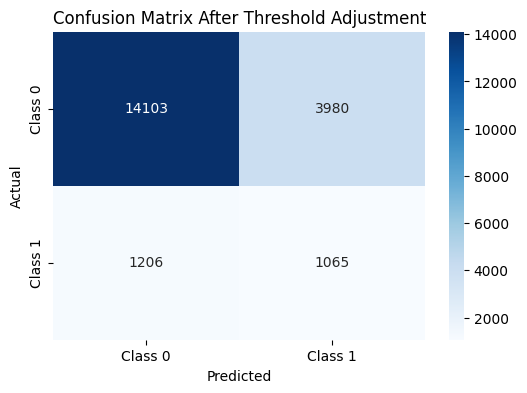

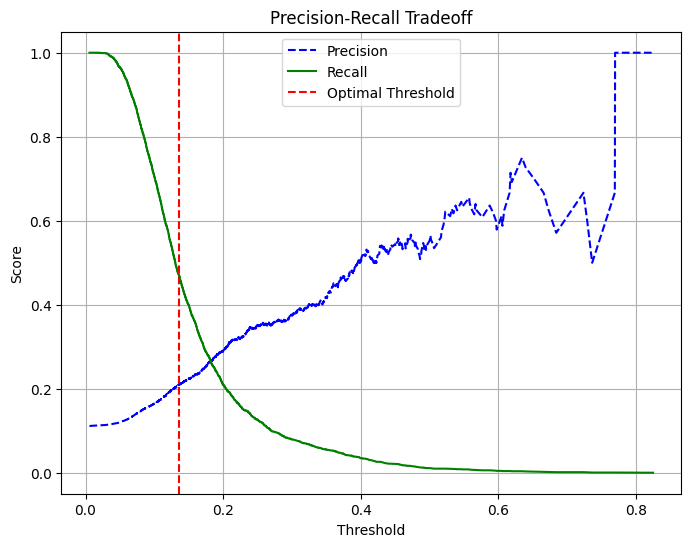


Best XGBoost model with selected features saved as 'best_xgb_model_selected_features.pkl'.


In [78]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    precision_recall_curve, 
    f1_score, 
    average_precision_score
)
import pandas as pd
import joblib


best_rf = grid_search_rf.best_estimator_
best_xgb = xgb_search.best_estimator_


print("\n--- Feature Importance Analysis ---")
feature_importances = pd.Series(best_xgb.feature_importances_, index=X_train.columns)

# Select Top N Features
top_n = 20  # Adjust as needed
top_features = feature_importances.nlargest(top_n).index.tolist()

print(f"Selected Top {top_n} Features: {top_features}")

# Use only top features for training
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

#Retrain Models on Selected Features
print("\n--- Retraining Models with Selected Features ---")
best_rf.fit(X_train_selected, y_train)
best_xgb.fit(X_train_selected, y_train)

#  Evaluate Models on Test Data
print("\n--- Random Forest Model Evaluation ---")
y_pred_rf = best_rf.predict(X_test_selected)
y_proba_rf = best_rf.predict_proba(X_test_selected)[:, 1]
print(classification_report(y_test, y_pred_rf))
print(f"Random Forest ROC-AUC Score: {roc_auc_score(y_test, y_proba_rf)}")

print("\n--- XGBoost Model Evaluation ---")
y_pred_xgb = best_xgb.predict(X_test_selected)
y_proba_xgb = best_xgb.predict_proba(X_test_selected)[:, 1]
print(classification_report(y_test, y_pred_xgb))
print(f"XGBoost ROC-AUC Score: {roc_auc_score(y_test, y_proba_xgb)}")

# Find the Optimal Threshold Using Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_xgb)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)  # Get index of best F1-score
optimal_threshold = thresholds[optimal_idx]
print(f"\nOptimal Threshold based on F1-score: {optimal_threshold}")

# Apply New Threshold to XGBoost Predictions
y_pred_adjusted = (y_proba_xgb >= optimal_threshold).astype(int)

#  Evaluate the Adjusted Model
print("\n--- XGBoost Model Evaluation After Threshold Adjustment ---")
print(classification_report(y_test, y_pred_adjusted))

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix After Threshold Adjustment")
plt.show()

#  Precision-Recall Curve Visualization
plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.axvline(optimal_threshold, color='r', linestyle="--", label="Optimal Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Precision-Recall Tradeoff")
plt.grid()
plt.show()

# Save the Best Model for Deployment
joblib.dump(best_xgb, "best_xgb_model_selected_features.pkl")
print("\nBest XGBoost model with selected features saved as 'best_xgb_model_selected_features.pkl'.")
